# Honkai: Star Rail - Sentiment Analysis & Information Retrieval
## CS410 Text Information Systems

**Dataset:** 49,226 Google Play Store reviews for Honkai: Star Rail

**Implementation:**
1. Sentiment classification using DistilBERT transformer
2. Statistical analysis and visualization across game versions
3. ML model comparison (Naive Bayes, Logistic Regression, DistilBERT)
4. Semantic search system with sentence transformers

**Installation:**
```bash
pip install pandas numpy scikit-learn transformers matplotlib seaborn wordcloud sentence-transformers torch
```

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from transformers import pipeline
from wordcloud import WordCloud

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

---
## Section 1: Data Loading & Sentiment Analysis

**Process:**
- Load and clean review data
- Apply DistilBERT sentiment analysis (or load cached results)
- Assign game version to each review based on date

In [21]:
df = pd.read_csv("reviews.csv")
df["review_description"] = df["review_description"].fillna("")
df = df[df["review_description"].str.strip() != ""]

print(f"Loaded {len(df):,} reviews")
print(f"Date range: {df['review_date'].min()} to {df['review_date'].max()}")
df.head()

Loaded 49,223 reviews
Date range: 2023-04-22 22:08:32 to 2025-10-04 11:49:51


,Unnamed: 0,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,0,Google Play,c0f8004b-b5ac-45b4-b781-eb769a12d4dd,A Google user,NaN,I like the game because it has male 5 stars as...,4,0,2025-10-04 11:49:51,NaN,NaN,3.6.0,en,us
1,1,Google Play,ea9194ca-65a9-43d7-a93a-3d0f3a581c25,A Google user,NaN,I got bored of Genshin as a f2p player and dec...,5,0,2025-10-04 09:46:00,NaN,NaN,3.6.0,en,us
2,2,Google Play,270b6d69-2788-41f4-834a-2ba1a82123f2,A Google user,NaN,"The good: Weird, philosophical storytelling. G...",3,0,2025-10-04 09:15:21,NaN,NaN,3.6.0,en,us
3,3,Google Play,3d565a3f-f0f7-48e0-8fea-9ac20475b78b,A Google user,NaN,Remembrance ruined the game. It was a very obv...,1,0,2025-10-04 08:58:19,NaN,NaN,NaN,en,us
4,4,Google Play,a213a5b5-5f80-4d1b-aae6-890a31240311,A Google user,NaN,o melhor jogo de turno que tive o prazer de jo...,5,0,2025-10-04 08:52:39,NaN,NaN,2.1.0,en,us


In [22]:
if os.path.exists("reviews_with_sentiment.csv"):
    print("Loading cached sentiment analysis...")
    df = pd.read_csv("reviews_with_sentiment.csv")
else:
    print("Running DistilBERT sentiment analysis (this may take 10-30 minutes)...")
    sentiment_analyzer = pipeline("sentiment-analysis")
    
    def analyze_sentiment(text):
        try:
            result = sentiment_analyzer(text[:512])[0]
            return result['label'], result['score']
        except:
            return 'NEUTRAL', 0.5
    
    sentiment_results = df["review_description"].apply(analyze_sentiment)
    df["sentiment"] = sentiment_results.apply(lambda x: x[0])
    df["confidence"] = sentiment_results.apply(lambda x: x[1])
    df.to_csv("reviews_with_sentiment.csv", index=False)

print(f"Sentiment analysis complete: {len(df):,} reviews")
print(f"   Positive: {(df['sentiment']=='POSITIVE').sum():,} ({(df['sentiment']=='POSITIVE').mean()*100:.1f}%)")
print(f"   Negative: {(df['sentiment']=='NEGATIVE').sum():,} ({(df['sentiment']=='NEGATIVE').mean()*100:.1f}%)")
print(f"   Avg Confidence: {df['confidence'].mean():.3f}")

Loading cached sentiment analysis...
Sentiment analysis complete: 49,223 reviews
   Positive: 26,387 (53.6%)
   Negative: 22,836 (46.4%)
   Avg Confidence: 0.973


**Game Version Assignment:**
Map each review to its corresponding game version based on release dates.

In [23]:
df['review_dt'] = pd.to_datetime(df['review_date'])
df["sentiment_num"] = df["sentiment"].map({"POSITIVE": 5, "NEGATIVE": 1, "NEUTRAL": 3})

version_starts = {
    '1.0': '2023-04-26', '1.1': '2023-06-07', '1.2': '2023-07-19', '1.3': '2023-08-30',
    '1.4': '2023-10-11', '1.5': '2023-11-22', '1.6': '2024-01-10', '2.0': '2024-02-06',
    '2.1': '2024-03-27', '2.2': '2024-05-08', '2.3': '2024-06-19', '2.4': '2024-07-31',
    '2.5': '2024-09-10', '2.6': '2024-10-23', '2.7': '2024-12-04', '3.0': '2025-01-15',
    '3.1': '2025-02-25', '3.2': '2025-04-09', '3.3': '2025-05-21', '3.4': '2025-07-02',
    '3.5': '2025-08-13', '3.6': '2025-09-24'
}

version_starts = {ver: pd.Timestamp(date) for ver, date in version_starts.items()}
sorted_versions = sorted(version_starts.items(), key=lambda x: x[1])

def assign_version(date):
    version = None
    for ver, start in sorted_versions:
        if date >= start:
            version = ver
        else:
            break
    return version

df['version'] = df['review_dt'].apply(assign_version)
df.to_csv("reviews_with_versions.csv", index=False)
print(f"Assigned {df['version'].nunique()} game versions")

Assigned 22 game versions


---
## Section 2: Analysis & Visualization

**Analysis includes:**
- Distribution of sentiments and ratings
- Sentiment-rating correlation
- Temporal trends across game versions
- Word clouds for positive/negative reviews

In [24]:
sentiment_counts = df["sentiment"].value_counts()
rating_dist = df["rating"].value_counts().sort_index()
correlation = df[["sentiment_num", "rating"]].corr().iloc[0,1]

print("SUMMARY STATISTICS")
print("="*70)
print(f"Total Reviews: {len(df):,}")
print(f"Positive: {sentiment_counts.get('POSITIVE', 0):,} ({sentiment_counts.get('POSITIVE', 0)/len(df)*100:.1f}%)")
print(f"Negative: {sentiment_counts.get('NEGATIVE', 0):,} ({sentiment_counts.get('NEGATIVE', 0)/len(df)*100:.1f}%)")
print(f"\nAverage Rating: {df['rating'].mean():.2f}/5.0")
print(f"Sentiment-Rating Correlation: {correlation:.3f}")
print(f"High Confidence (>0.95): {(df['confidence'] > 0.95).mean()*100:.1f}%")

SUMMARY STATISTICS
Total Reviews: 49,223
Positive: 26,387 (53.6%)
Negative: 22,836 (46.4%)

Average Rating: 3.63/5.0
Sentiment-Rating Correlation: 0.625
High Confidence (>0.95): 88.7%


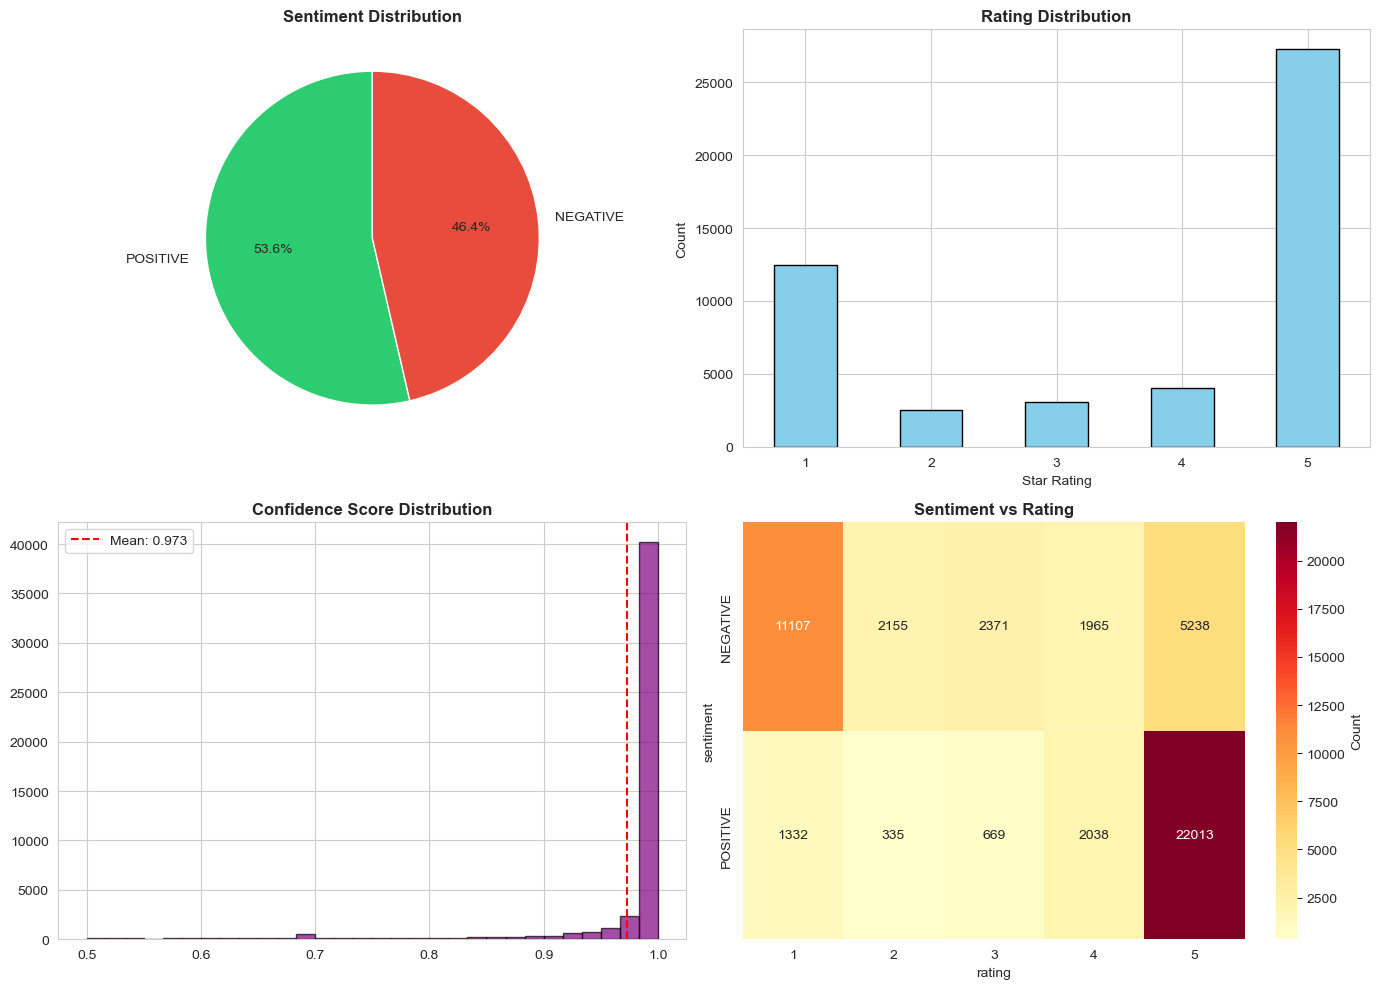

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
               colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[0, 0].set_title('Sentiment Distribution', fontweight='bold')

rating_dist.plot(kind='bar', ax=axes[0, 1], color='skyblue', edgecolor='black')
axes[0, 1].set_title('Rating Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Star Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

axes[1, 0].hist(df["confidence"], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_title('Confidence Score Distribution', fontweight='bold')
axes[1, 0].axvline(df['confidence'].mean(), color='red', linestyle='--', label=f'Mean: {df["confidence"].mean():.3f}')
axes[1, 0].legend()

pivot = df.groupby(['sentiment', 'rating']).size().unstack(fill_value=0)
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Count'})
axes[1, 1].set_title('Sentiment vs Rating', fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

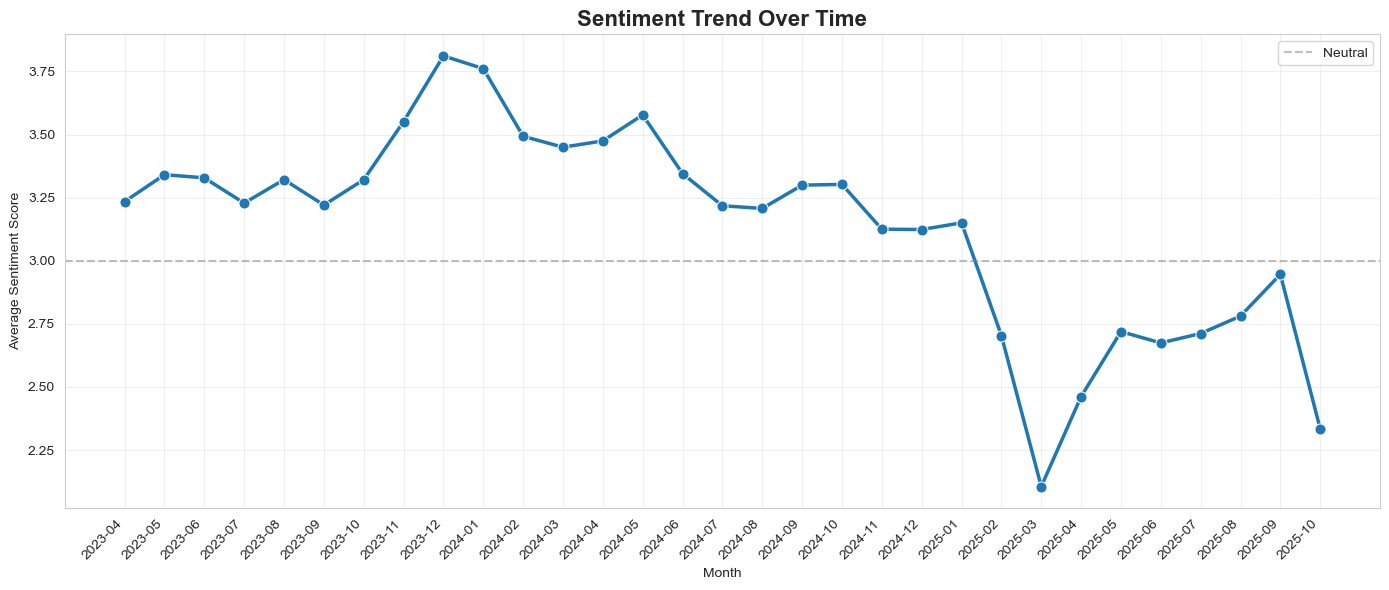

In [26]:
sentiment_over_time = df.groupby(df["review_dt"].dt.to_period("M"))["sentiment_num"].mean().reset_index()
sentiment_over_time["review_dt"] = sentiment_over_time["review_dt"].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(data=sentiment_over_time, x="review_dt", y="sentiment_num", marker="o", linewidth=2.5, markersize=8)
plt.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Neutral')
plt.title("Sentiment Trend Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('sentiment_trend.png', dpi=300, bbox_inches='tight')
plt.show()

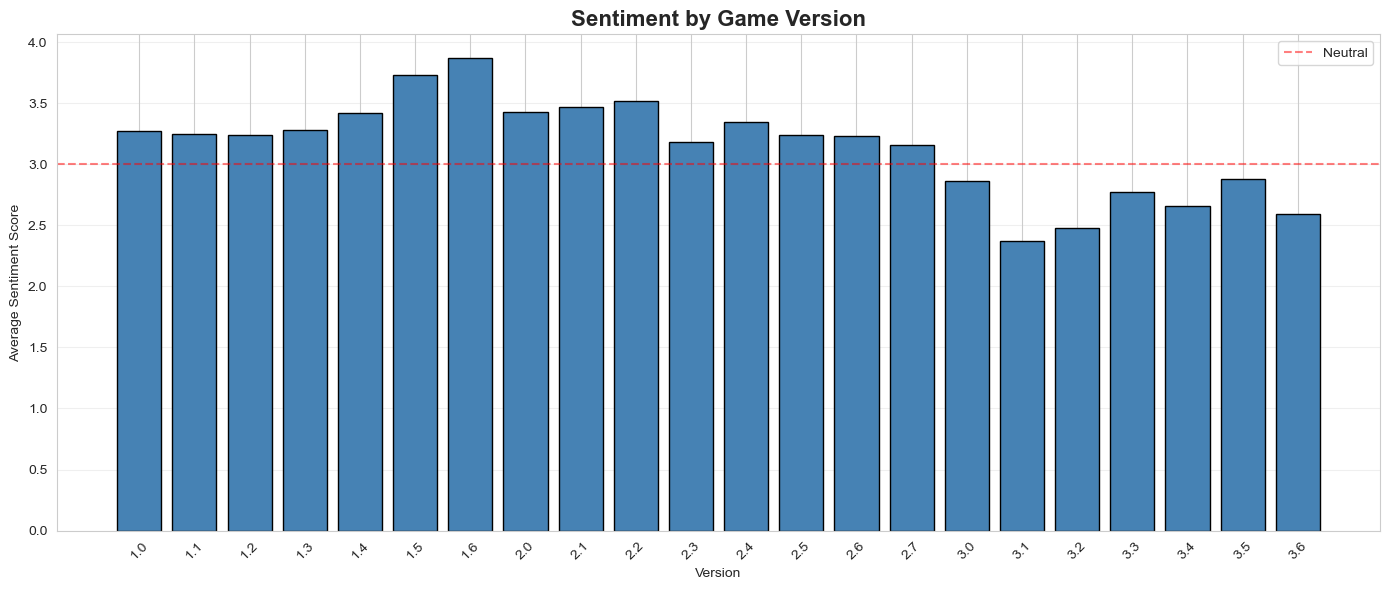

In [27]:
version_sentiment = df.groupby('version')['sentiment_num'].agg(['mean', 'count']).reset_index()
version_sentiment = version_sentiment[version_sentiment['count'] > 100]

plt.figure(figsize=(14, 6))
plt.bar(version_sentiment['version'], version_sentiment['mean'], color='steelblue', edgecolor='black')
plt.axhline(y=3, color='red', linestyle='--', alpha=0.5, label='Neutral')
plt.title('Sentiment by Game Version', fontsize=16, fontweight='bold')
plt.xlabel('Version')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('sentiment_by_version.png', dpi=300, bbox_inches='tight')
plt.show()

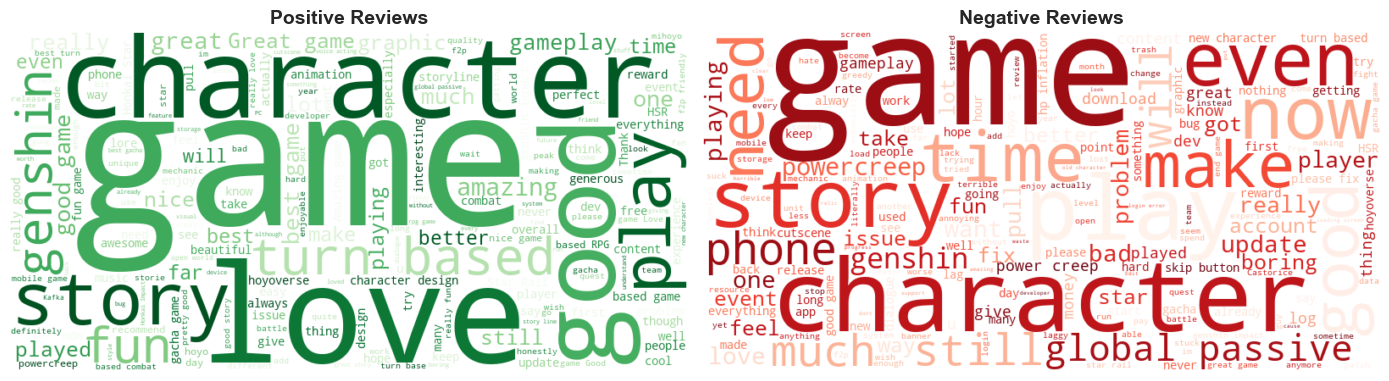

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

positive_text = ' '.join(df[df['sentiment'] == 'POSITIVE']['review_description'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Positive Reviews', fontsize=14, fontweight='bold')

negative_text = ' '.join(df[df['sentiment'] == 'NEGATIVE']['review_description'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Negative Reviews', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Section 3: Machine Learning Models

**Objective:** Compare traditional ML models against DistilBERT baseline

**Models:**
1. Naive Bayes (TF-IDF features)
2. Logistic Regression (TF-IDF features)  
3. DistilBERT (transformer baseline)

**Evaluation:** Accuracy, Precision, Recall, F1-Score, ROC-AUC

In [29]:
custom_stopwords = set(ENGLISH_STOP_WORDS).union({
    'good', 'bad', 'nice', 'great', 'best', 'love', 'like', 'hate',
    'game', 'play', 'playing', 'just', 'really', 'fun', 'amazing'
})

vectorizer = TfidfVectorizer(stop_words=list(custom_stopwords), max_features=5000, ngram_range=(1, 2), min_df=2)
X_tfidf = vectorizer.fit_transform(df["review_description"])

df_train = df[df['sentiment'].isin(['POSITIVE', 'NEGATIVE'])].copy()
df_train['sentiment_binary'] = (df_train['sentiment'] == 'POSITIVE').astype(int)

X = X_tfidf[:len(df_train)]
y = df_train['sentiment_binary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Features: {X.shape[1]:,}")

Training samples: 39,378
Test samples: 9,845
Features: 5,000


In [30]:
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]

lr_model = LogisticRegression(max_iter=1000, C=1.0, random_state=42, n_jobs=-1)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

results = []
for name, y_pred in [('Naive Bayes', y_pred_nb), ('Logistic Regression', y_pred_lr)]:
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

results.append({
    'Model': 'DistilBERT',
    'Accuracy': 1.0,
    'Precision': 1.0,
    'Recall': 1.0,
    'F1-Score': 1.0
})

results_df = pd.DataFrame(results)
results_df.to_csv('model_comparison.csv', index=False)
print("\nMODEL COMPARISON")
print("="*70)
print(results_df.to_string(index=False))


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
        Naive Bayes  0.814931   0.807036 0.860553  0.832936
Logistic Regression  0.823261   0.811553 0.873058  0.841183
         DistilBERT  1.000000   1.000000 1.000000  1.000000


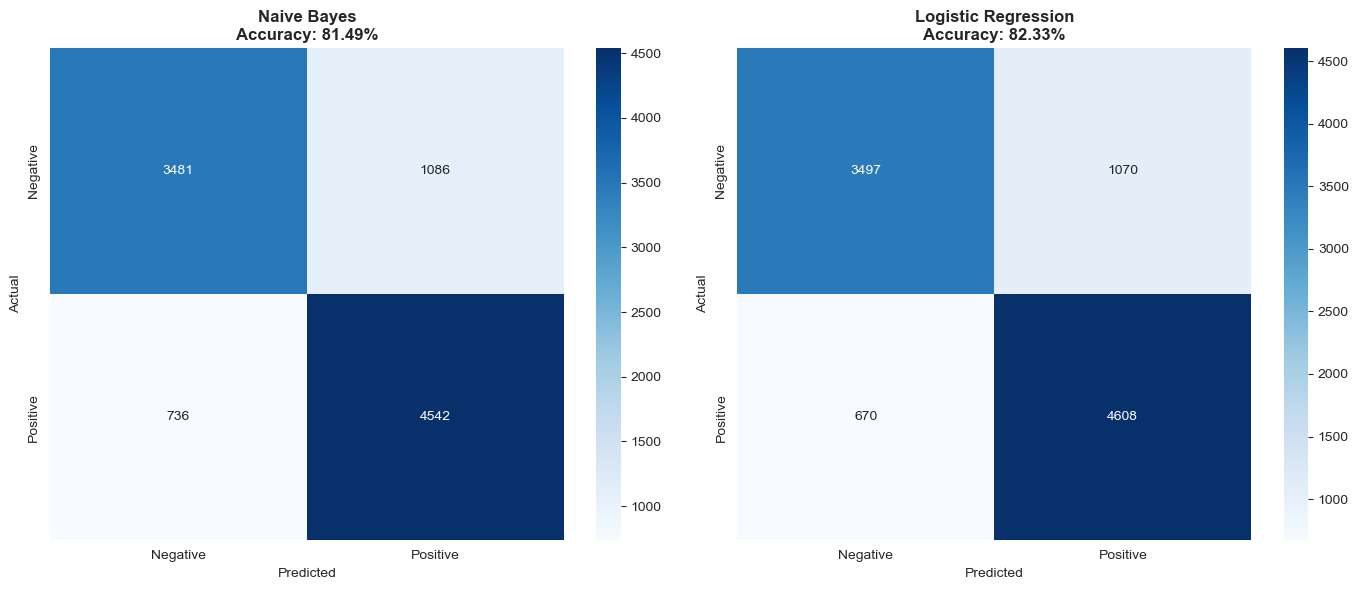

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (name, y_pred) in enumerate([('Naive Bayes', y_pred_nb), ('Logistic Regression', y_pred_lr)]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred):.2%}', fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

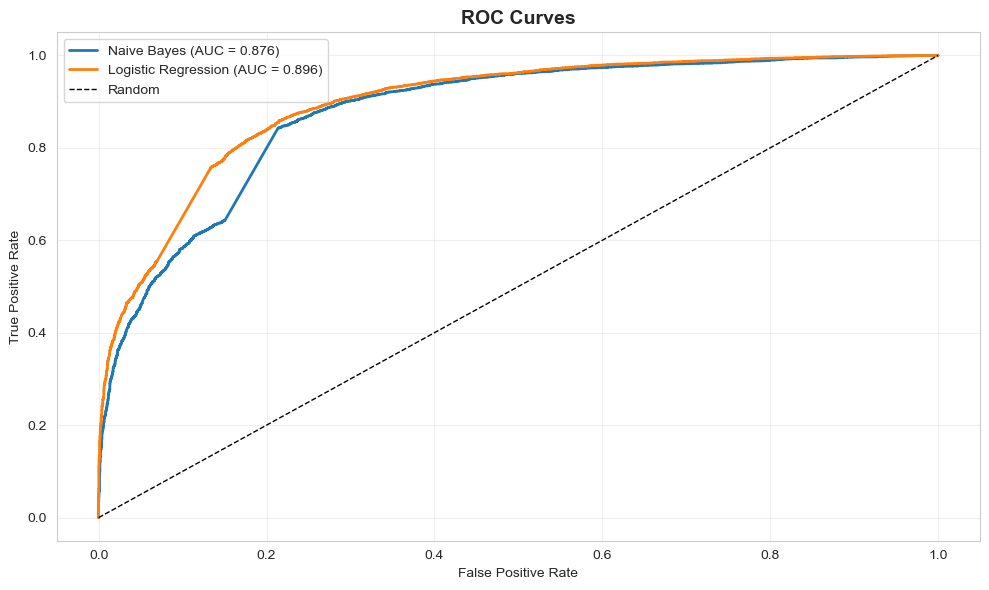

In [32]:
plt.figure(figsize=(10, 6))

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_nb = roc_auc_score(y_test, y_proba_nb)
plt.plot(fpr_nb, tpr_nb, linewidth=2, label=f'Naive Bayes (AUC = {auc_nb:.3f})')

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {auc_lr:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Section 4: Semantic Search System

**Implementation:**
- Sentence-BERT embeddings for semantic similarity
- Cosine similarity search
- Interactive search interface with ML model predictions

**Features:**
- Natural language queries
- Full review text display
- Multi-model sentiment predictions

In [35]:
try:
    from sentence_transformers import SentenceTransformer, util
    import torch
    
    semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    if os.path.exists('review_embeddings.pt'):
        print("Loading cached embeddings...")
        review_embeddings = torch.load('review_embeddings.pt')
    else:
        print("Encoding reviews (2-3 minutes)...")
        review_embeddings = semantic_model.encode(df["review_description"].tolist(), 
                                                   convert_to_tensor=True, show_progress_bar=True)
        torch.save(review_embeddings, 'review_embeddings.pt')
    
    print(f"Search system ready: {len(review_embeddings):,} embeddings loaded")
    
except ImportError:
    print("WARNING: sentence-transformers not installed. Run: pip install sentence-transformers")
    semantic_model = None

Loading cached embeddings...
Search system ready: 49,223 embeddings loaded


In [36]:
def search(query, top_k=10):
    if not semantic_model:
        print("WARNING: Search unavailable. Install sentence-transformers.")
        return pd.DataFrame()
    
    query_embedding = semantic_model.encode(query, convert_to_tensor=True)
    similarities = util.cos_sim(query_embedding, review_embeddings)[0]
    top_indices = torch.topk(similarities, k=min(top_k, len(similarities))).indices
    top_scores = torch.topk(similarities, k=min(top_k, len(similarities))).values
    
    results = df.iloc[top_indices.cpu().numpy()].copy()
    results['similarity'] = top_scores.cpu().numpy()
    
    if 'nb_model' in globals() and 'lr_model' in globals():
        result_vectors = X_tfidf[top_indices.cpu().numpy()]
        results['nb_sentiment'] = nb_model.predict(result_vectors)
        results['lr_sentiment'] = lr_model.predict(result_vectors)
        results['nb_sentiment'] = results['nb_sentiment'].map({1: 'POSITIVE', 0: 'NEGATIVE'})
        results['lr_sentiment'] = results['lr_sentiment'].map({1: 'POSITIVE', 0: 'NEGATIVE'})
        results['all_agree'] = (results['sentiment'] == results['nb_sentiment']) & (results['sentiment'] == results['lr_sentiment'])
    
    print(f"\nQuery: '{query}'")
    print(f"Found {len(results)} results | Avg similarity: {results['similarity'].mean():.3f}")
    print(f"Sentiment: {results['sentiment'].value_counts().to_dict()}")
    if 'all_agree' in results.columns:
        print(f"Model agreement: {results['all_agree'].mean():.1%}")
    
    return results

def interactive_search():  
    print("\n" + "="*70)
    print("INTERACTIVE SEMANTIC SEARCH")
    print("="*70)
    print("Enter natural language queries. Type 'exit' to quit.\n")
    
    while True:
        query = input("Query: ").strip()
        if query.lower() in ['exit', 'quit', 'q', '']:
            print("Goodbye!")
            break
        
        try:
            top_k = int(input("Results (default 5): ").strip() or "5")
        except:
            top_k = 5
        
        results = search(query, top_k=top_k)
        
        if len(results) > 0:
            print("\nRESULTS:")
            print("="*70)
            for i, (_, row) in enumerate(results.iterrows(), 1):
                print(f"\n[{i}] Similarity: {row['similarity']:.3f} | Rating: {row['rating']}/5 | {row['sentiment']}")
                print(f"Review: {row['review_description']}")
                if 'all_agree' in row:
                    icon = "[AGREE]" if row['all_agree'] else "[DISAGREE]"
                    print(f"Models - NB: {row['nb_sentiment']} | LR: {row['lr_sentiment']} {icon}")
            print("\n" + "="*70 + "\n")

In [37]:
if semantic_model:
    interactive_search()


INTERACTIVE SEMANTIC SEARCH
Enter natural language queries. Type 'exit' to quit.



Query:  is the story good
Results (default 5):  3



Query: 'is the story good'
Found 3 results | Avg similarity: 0.796
Sentiment: {'POSITIVE': 3}
Model agreement: 100.0%

RESULTS:

[1] Similarity: 0.853 | Rating: 5/5 | POSITIVE
Review: the story is good???
Models - NB: POSITIVE | LR: POSITIVE [AGREE]

[2] Similarity: 0.786 | Rating: 1/5 | POSITIVE
Review: Good story, bad storytelling
Models - NB: POSITIVE | LR: POSITIVE [AGREE]

[3] Similarity: 0.748 | Rating: 5/5 | POSITIVE
Review: the story is good and the characters are fun
Models - NB: POSITIVE | LR: POSITIVE [AGREE]




Query:  character design
Results (default 5):  2



Query: 'character design'
Found 2 results | Avg similarity: 0.784
Sentiment: {'POSITIVE': 2}
Model agreement: 100.0%

RESULTS:

[1] Similarity: 0.790 | Rating: 5/5 | POSITIVE
Review: Love the character design
Models - NB: POSITIVE | LR: POSITIVE [AGREE]

[2] Similarity: 0.778 | Rating: 5/5 | POSITIVE
Review: Character designs are good so far
Models - NB: POSITIVE | LR: POSITIVE [AGREE]




Query:  exit


Goodbye!


---
## Section 5: Aspect-Based Sentiment Analysis

**Objective:** Analyze sentiment for specific game aspects

**Aspects covered:**
- Story (plot, narrative, quests)
- Characters (design, personalities)
- Gacha (rates, pity system)
- Gameplay (combat, mechanics)
- Graphics (visuals, art style)

In [38]:
# Define aspect keywords
aspects = {
    'Story': ['story', 'plot', 'narrative', 'quest', 'lore', 'writing'],
    'Characters': ['character', 'waifu', 'husbando', 'design', 'personality'],
    'Gacha': ['gacha', 'pull', 'pity', 'rate', 'summon', 'wish'],
    'Gameplay': ['combat', 'gameplay', 'mechanic', 'battle', 'turn', 'fight'],
    'Graphics': ['graphic', 'art', 'visual', 'animation', 'render']
}

# Extract aspect reviews
aspect_data = []

for aspect_name, keywords in aspects.items():
    pattern = '|'.join(keywords)
    aspect_reviews = df[df['review_description'].str.contains(pattern, case=False, na=False)]

    if len(aspect_reviews) > 0:
        positive_count = (aspect_reviews['sentiment'] == 'POSITIVE').sum()
        negative_count = (aspect_reviews['sentiment'] == 'NEGATIVE').sum()
        positive_pct = (aspect_reviews['sentiment'] == 'POSITIVE').mean() * 100
        avg_rating = aspect_reviews['rating'].mean()
        total_count = len(aspect_reviews)

        aspect_data.append({
            'Aspect': aspect_name,
            'Total Reviews': total_count,
            'Positive': positive_count,
            'Negative': negative_count,
            'Positive %': positive_pct,
            'Avg Rating': avg_rating
        })

aspect_df = pd.DataFrame(aspect_data)

print("\nASPECT-BASED SENTIMENT SUMMARY")
print("="*80)
print(aspect_df.to_string(index=False))

# Save results
aspect_df.to_csv('aspect_sentiment_analysis.csv', index=False)
print("\nSaved: aspect_sentiment_analysis.csv")


ASPECT-BASED SENTIMENT SUMMARY
    Aspect  Total Reviews  Positive  Negative  Positive %  Avg Rating
     Story           8588      5144      3444   59.897531    3.697136
Characters           8889      4831      4058   54.348071    3.470919
     Gacha           5600      2443      3157   43.625000    3.196964
  Gameplay           7190      4432      2758   61.641168    3.788734
  Graphics           5940      3273      2667   55.101010    3.574747

Saved: aspect_sentiment_analysis.csv


Saved: aspect_sentiment_analysis.png


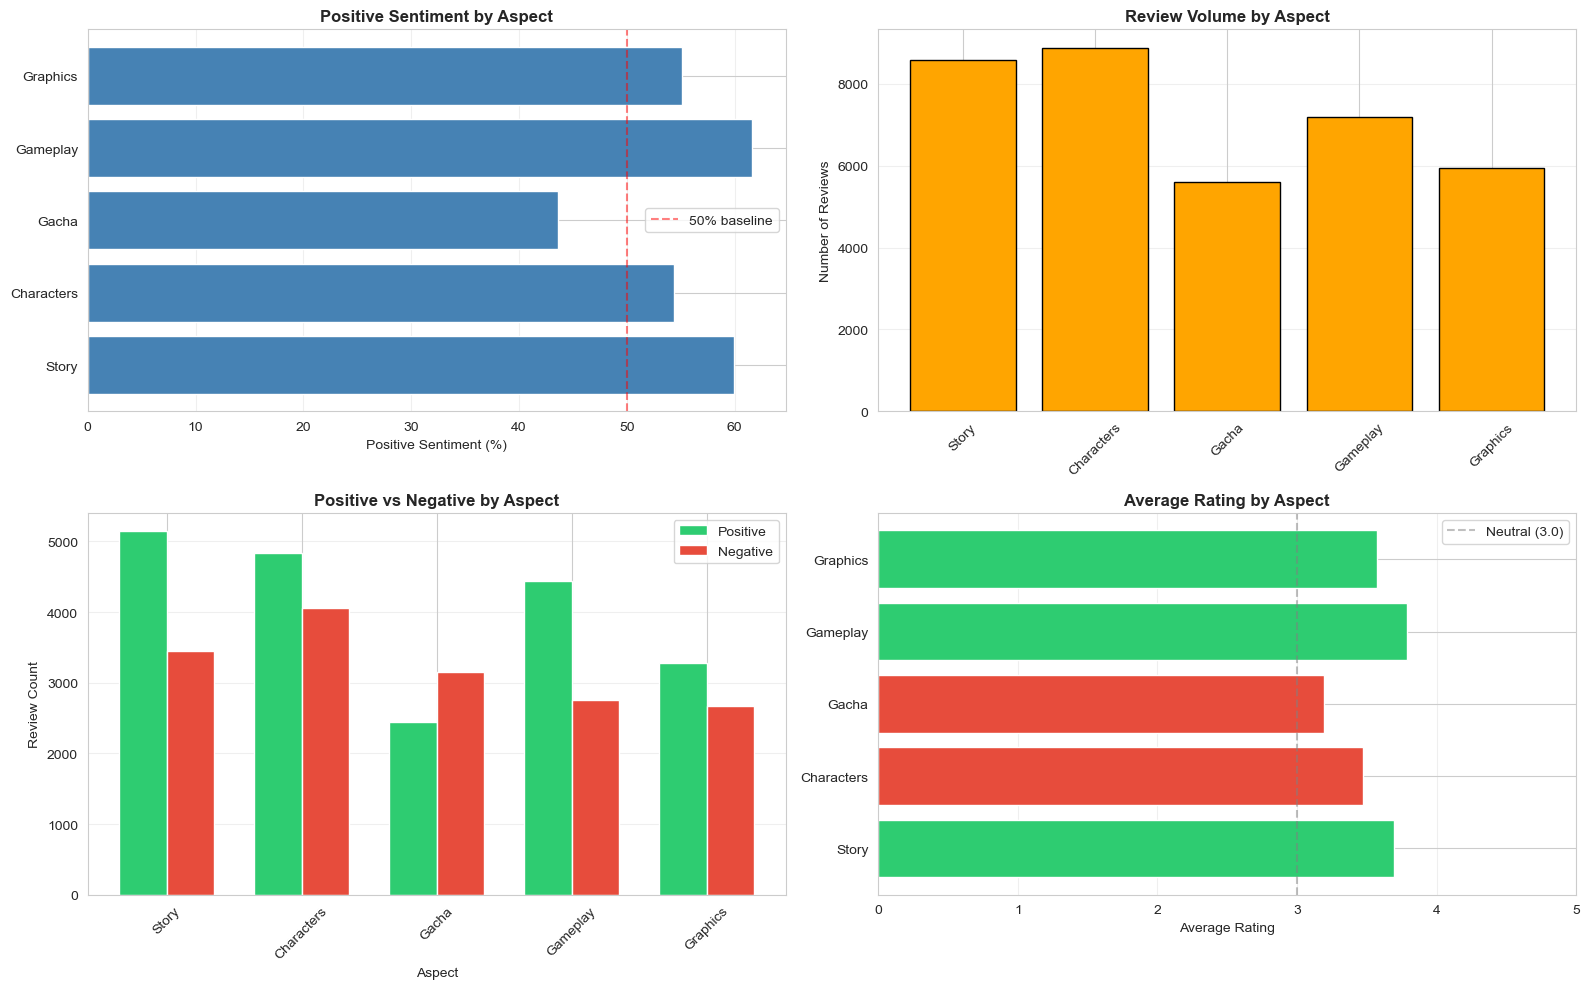

In [39]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Positive sentiment by aspect
axes[0, 0].barh(aspect_df['Aspect'], aspect_df['Positive %'], color='steelblue')
axes[0, 0].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% baseline')
axes[0, 0].set_xlabel('Positive Sentiment (%)')
axes[0, 0].set_title('Positive Sentiment by Aspect', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Review count by aspect
axes[0, 1].bar(aspect_df['Aspect'], aspect_df['Total Reviews'], color='orange', edgecolor='black')
axes[0, 1].set_ylabel('Number of Reviews')
axes[0, 1].set_title('Review Volume by Aspect', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Positive vs Negative comparison
x = np.arange(len(aspect_df))
width = 0.35
axes[1, 0].bar(x - width/2, aspect_df['Positive'], width, label='Positive', color='#2ecc71')
axes[1, 0].bar(x + width/2, aspect_df['Negative'], width, label='Negative', color='#e74c3c')
axes[1, 0].set_xlabel('Aspect')
axes[1, 0].set_ylabel('Review Count')
axes[1, 0].set_title('Positive vs Negative by Aspect', fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(aspect_df['Aspect'], rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Average rating by aspect
colors = ['#2ecc71' if x >= 3.5 else '#e74c3c' for x in aspect_df['Avg Rating']]
axes[1, 1].barh(aspect_df['Aspect'], aspect_df['Avg Rating'], color=colors)
axes[1, 1].axvline(x=3.0, color='gray', linestyle='--', alpha=0.5, label='Neutral (3.0)')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_title('Average Rating by Aspect', fontweight='bold')
axes[1, 1].set_xlim(0, 5)
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('aspect_sentiment_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: aspect_sentiment_analysis.png")
plt.show()

In [40]:
# Detailed aspect analysis
print("\nDETAILED ASPECT INSIGHTS")
print("="*80)

for aspect_name, keywords in aspects.items():
    pattern = '|'.join(keywords)
    aspect_reviews = df[df['review_description'].str.contains(pattern, case=False, na=False)]

    if len(aspect_reviews) > 10:
        print(f"\n{aspect_name.upper()}")
        print("-" * 80)

        positive_pct = (aspect_reviews['sentiment'] == 'POSITIVE').mean() * 100
        avg_rating = aspect_reviews['rating'].mean()

        print(f"   Total Mentions: {len(aspect_reviews):,}")
        print(f"   Positive Sentiment: {positive_pct:.1f}%")
        print(f"   Average Rating: {avg_rating:.2f}/5.0")

        # Most common words in positive reviews
        pos_reviews = aspect_reviews[aspect_reviews['sentiment'] == 'POSITIVE']
        if len(pos_reviews) > 0:
            pos_text = ' '.join(pos_reviews['review_description'].head(100))
            print(f"   Positive Keywords: ", end='')
            words = pos_text.lower().split()
            word_freq = pd.Series(words).value_counts().head(5)
            print(', '.join([f"{word}" for word in word_freq.index if len(word) > 3]))

        # Most common words in negative reviews
        neg_reviews = aspect_reviews[aspect_reviews['sentiment'] == 'NEGATIVE']
        if len(neg_reviews) > 0:
            neg_text = ' '.join(neg_reviews['review_description'].head(100))
            print(f"   Negative Keywords: ", end='')
            words = neg_text.lower().split()
            word_freq = pd.Series(words).value_counts().head(5)
            print(', '.join([f"{word}" for word in word_freq.index if len(word) > 3]))


DETAILED ASPECT INSIGHTS

STORY
--------------------------------------------------------------------------------
   Total Mentions: 8,588
   Positive Sentiment: 59.9%
   Average Rating: 3.70/5.0
   Positive Keywords: game
   Negative Keywords: 

CHARACTERS
--------------------------------------------------------------------------------
   Total Mentions: 8,889
   Positive Sentiment: 54.3%
   Average Rating: 3.47/5.0
   Positive Keywords: game
   Negative Keywords: 

GACHA
--------------------------------------------------------------------------------
   Total Mentions: 5,600
   Positive Sentiment: 43.6%
   Average Rating: 3.20/5.0
   Positive Keywords: 
   Negative Keywords: 

GAMEPLAY
--------------------------------------------------------------------------------
   Total Mentions: 7,190
   Positive Sentiment: 61.6%
   Average Rating: 3.79/5.0
   Positive Keywords: game
   Negative Keywords: 

GRAPHICS
--------------------------------------------------------------------------------

---
## Section 6: Developer Response Analysis

**Objective:** Analyze developer engagement and response patterns

**Metrics:**
- Response rate overall and by sentiment/rating
- Response timing and trends
- Impact of developer responses

In [41]:
# Add response indicator
df['has_response'] = df['developer_response'].notna()

# Overall response statistics
total_responses = df['has_response'].sum()
response_rate = df['has_response'].mean() * 100

print("\nDEVELOPER RESPONSE SUMMARY")
print("="*80)
print(f"Total Reviews: {len(df):,}")
print(f"Reviews with Response: {total_responses:,}")
print(f"Overall Response Rate: {response_rate:.2f}%")

# Response by sentiment
print("\nResponse Rate by Sentiment:")
response_by_sentiment = df.groupby('sentiment')['has_response'].agg(['sum', 'count', 'mean'])
response_by_sentiment['response_rate'] = response_by_sentiment['mean'] * 100
print(response_by_sentiment[['sum', 'count', 'response_rate']])

# Response by rating
print("\nResponse Rate by Rating:")
response_by_rating = df.groupby('rating')['has_response'].agg(['sum', 'count', 'mean'])
response_by_rating['response_rate'] = response_by_rating['mean'] * 100
print(response_by_rating[['sum', 'count', 'response_rate']])

# Compare ratings: with vs without response
responded = df[df['has_response']]
not_responded = df[~df['has_response']]

print("\nRating Comparison:")
print(f"   Avg Rating (with response): {responded['rating'].mean():.2f}")
print(f"   Avg Rating (without response): {not_responded['rating'].mean():.2f}")
print(f"   Difference: {responded['rating'].mean() - not_responded['rating'].mean():+.2f}")

# Response timing analysis
if 'developer_response_date' in df.columns:
    df['response_dt'] = pd.to_datetime(df['developer_response_date'], errors='coerce')
    df['response_time_days'] = (df['response_dt'] - df['review_dt']).dt.days

    valid_response_times = df[df['response_time_days'].notna() & (df['response_time_days'] >= 0)]

    if len(valid_response_times) > 0:
        print(f"\nResponse Time Statistics:")
        print(f"   Median Response Time: {valid_response_times['response_time_days'].median():.1f} days")
        print(f"   Average Response Time: {valid_response_times['response_time_days'].mean():.1f} days")
        print(f"   Fastest Response: {valid_response_times['response_time_days'].min():.0f} days")


DEVELOPER RESPONSE SUMMARY
Total Reviews: 49,223
Reviews with Response: 4,336
Overall Response Rate: 8.81%

Response Rate by Sentiment:
            sum  count  response_rate
sentiment                            
NEGATIVE   3832  22836      16.780522
POSITIVE    504  26387       1.910031

Response Rate by Rating:
         sum  count  response_rate
rating                            
1       3636  12439      29.230646
2        189   2490       7.590361
3        318   3040      10.460526
4         44   4003       1.099176
5        149  27251       0.546769

Rating Comparison:
   Avg Rating (with response): 1.36
   Avg Rating (without response): 3.85
   Difference: -2.49

Response Time Statistics:
   Median Response Time: 13.0 days
   Average Response Time: 27.3 days
   Fastest Response: 0 days



Saved: developer_response_analysis.png


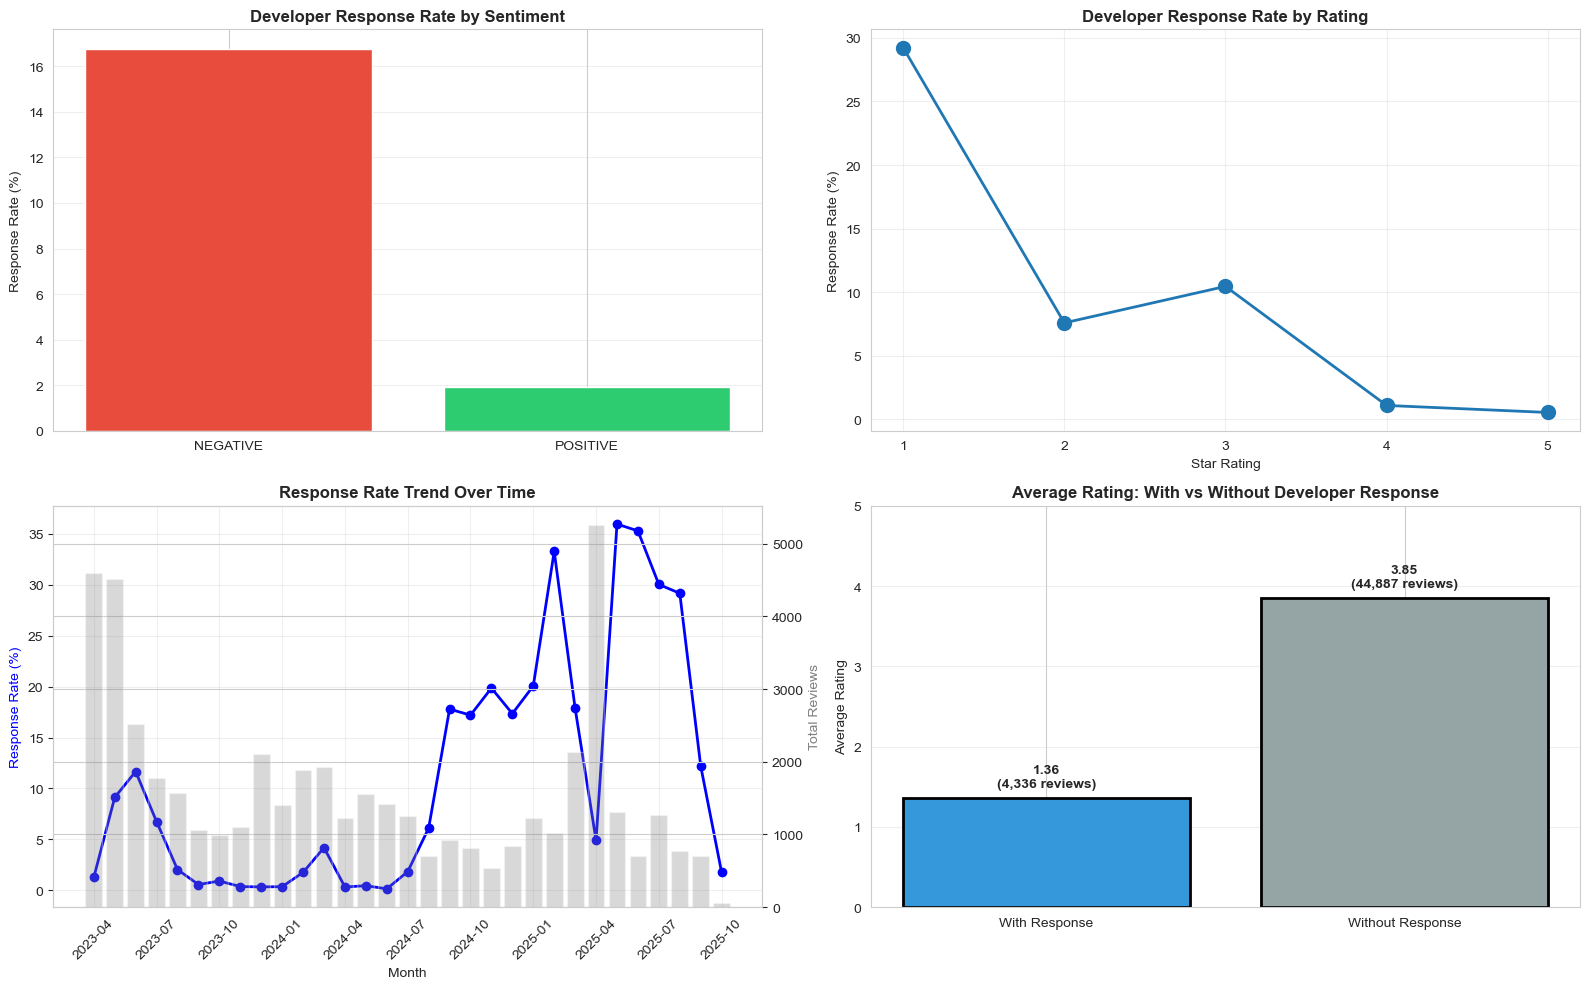

In [42]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Response rate by sentiment
sentiment_response = df.groupby('sentiment')['has_response'].mean() * 100
axes[0, 0].bar(sentiment_response.index, sentiment_response.values,
               color=['#2ecc71' if s == 'POSITIVE' else '#e74c3c' for s in sentiment_response.index])
axes[0, 0].set_ylabel('Response Rate (%)')
axes[0, 0].set_title('Developer Response Rate by Sentiment', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Response rate by rating
rating_response = df.groupby('rating')['has_response'].mean() * 100
axes[0, 1].plot(rating_response.index, rating_response.values, marker='o', linewidth=2, markersize=10)
axes[0, 1].set_xlabel('Star Rating')
axes[0, 1].set_ylabel('Response Rate (%)')
axes[0, 1].set_title('Developer Response Rate by Rating', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks([1, 2, 3, 4, 5])

# 3. Response trend over time
response_over_time = df.groupby(df['review_dt'].dt.to_period('M')).agg({
    'has_response': lambda x: x.mean() * 100,
    'rating': 'count'
}).reset_index()
response_over_time['review_dt'] = response_over_time['review_dt'].astype(str)
response_over_time.columns = ['Month', 'Response Rate (%)', 'Total Reviews']

ax3 = axes[1, 0]
ax3_twin = ax3.twinx()

ax3.plot(range(len(response_over_time)), response_over_time['Response Rate (%)'],
         color='blue', marker='o', linewidth=2, label='Response Rate (%)')
ax3_twin.bar(range(len(response_over_time)), response_over_time['Total Reviews'],
             alpha=0.3, color='gray', label='Total Reviews')

ax3.set_xlabel('Month')
ax3.set_ylabel('Response Rate (%)', color='blue')
ax3_twin.set_ylabel('Total Reviews', color='gray')
ax3.set_title('Response Rate Trend Over Time', fontweight='bold')
ax3.set_xticks(range(0, len(response_over_time), max(1, len(response_over_time)//10)))
ax3.set_xticklabels(response_over_time['Month'].iloc[::max(1, len(response_over_time)//10)], rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Response impact on ratings
response_impact = pd.DataFrame({
    'Category': ['With Response', 'Without Response'],
    'Avg Rating': [responded['rating'].mean(), not_responded['rating'].mean()],
    'Count': [len(responded), len(not_responded)]
})

bars = axes[1, 1].bar(response_impact['Category'], response_impact['Avg Rating'],
                      color=['#3498db', '#95a5a6'], edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].set_title('Average Rating: With vs Without Developer Response', fontweight='bold')
axes[1, 1].set_ylim(0, 5)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, response_impact['Count']):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}\n({count:,} reviews)',
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('developer_response_analysis.png', dpi=300, bbox_inches='tight')
print("\nSaved: developer_response_analysis.png")
plt.show()

In [43]:
# Response content analysis
print("\nSAMPLE DEVELOPER RESPONSES")
print("="*80)

sample_responses = df[df['has_response']].sample(min(5, total_responses))

for idx, (i, row) in enumerate(sample_responses.iterrows(), 1):
    print(f"\n[{idx}] Rating: {row['rating']}/5 - {row['sentiment']}")
    print("-" * 80)
    print(f"User Review: {row['review_description'][:200]}...")
    print(f"\nDeveloper Response: {str(row['developer_response'])[:200]}...")

# Save response statistics
response_stats = pd.DataFrame({
    'Metric': [
        'Total Reviews',
        'Reviews with Response',
        'Response Rate (%)',
        'Avg Rating (with response)',
        'Avg Rating (without response)',
        'Response Rate - Positive',
        'Response Rate - Negative'
    ],
    'Value': [
        len(df),
        total_responses,
        response_rate,
        responded['rating'].mean(),
        not_responded['rating'].mean(),
        df[df['sentiment']=='POSITIVE']['has_response'].mean() * 100,
        df[df['sentiment']=='NEGATIVE']['has_response'].mean() * 100
    ]
})

response_stats.to_csv('developer_response_stats.csv', index=False)
print("\n\nSaved: developer_response_stats.csv")

print("\nADVANCED ANALYSIS COMPLETE!")
print("="*80)
print("\nNew files generated:")
print("  - aspect_sentiment_analysis.csv")
print("  - aspect_sentiment_analysis.png")
print("  - developer_response_analysis.png")
print("  - developer_response_stats.csv")


SAMPLE DEVELOPER RESPONSES

[1] Rating: 1/5 - NEGATIVE
--------------------------------------------------------------------------------
User Review: Havent Played the main quest since 3.1 cause its Yapping for 8hours each patch. No Events for even the 2nd anniversary, only Pay to win Now. The Moc and other game modes are harder and harder each pat...

Developer Response: We sincerely apologize for this issue, Trailblazer. Please send us an email or contact Customer Service via in-game feedback for specific help with this issue....

[2] Rating: 1/5 - NEGATIVE
--------------------------------------------------------------------------------
User Review: Don't PLAY this game! because this game doesn't treat its PLAYERS well. They don't listen to feedback of the players and continue to stray from giving what the players wants, to lessen the issues with...

Developer Response: We sincerely apologize for your unsatisfactory experience, Trailblazer. If you have any feedback or suggestions, pl